In [1]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def flatten(list_of_list):
    return [item for sublist in list_of_list for item in sublist]

def read_transcription(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def create_dataframe(dialogue_id, transcription):
    rows = []

    # Iterate through all sentences in the transcription
    for index, sentence in enumerate(transcription):
        speaker = sentence['speaker']

        # Get the sentence text
        text = sentence['text']

        # Add a row to the DataFrame
        rows.append({
            'dialogue_id': dialogue_id,
            'index': index,
            'text': text,
            'speaker_text': speaker,
        })

    # Create the DataFrame
    df = pd.DataFrame(rows)

    return df

# Function to get labels for a dialogue
def get_label(dialogue_id, index,labels_data):
    return labels_data.get(dialogue_id, [])[index]

In [3]:
# Remplacez 'votre_chemin' par le chemin correct
path_train= Path("data/training")
path_test= Path("data/test")

# Remplacez 'vos_dialogue_ids' par votre liste réelle d'identifiants de dialogue
training_set = ['ES2002', 'ES2005', 'ES2006', 'ES2007', 'ES2008', 'ES2009', 'ES2010', 'ES2012', 'ES2013', 'ES2015', 'ES2016', 'IS1000', 'IS1001', 'IS1002', 'IS1003', 'IS1004', 'IS1005', 'IS1006', 'IS1007', 'TS3005', 'TS3008', 'TS3009', 'TS3010', 'TS3011', 'TS3012']
training_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in training_set])
training_set.remove('IS1002a')
training_set.remove('IS1005d')
training_set.remove('TS3012c')

test_set = ['ES2003', 'ES2004', 'ES2011', 'ES2014', 'IS1008', 'IS1009', 'TS3003', 'TS3004', 'TS3006', 'TS3007']
test_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in test_set])

In [4]:
# Créer le DataFrame pour l'ensemble d'entraînement
dfs = []
for dialogue_id in training_set:
    transcription_data = read_transcription(path_train / f'{dialogue_id}.json')
    df = create_dataframe(dialogue_id, transcription_data)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

# Ajouter la colonne 'label' à df en utilisant la fonction get_label
with open("data/training_labels.json", 'r') as file:
    labels_data = json.load(file)

df['label'] = df.apply(lambda row: get_label(row['dialogue_id'], row['index'], labels_data), axis=1)

# Créer le DataFrame pour l'ensemble de test
dfs_test = []
for dialogue_id in test_set:
    transcription_data = read_transcription(path_test / f'{dialogue_id}.json')
    df_test = create_dataframe(dialogue_id, transcription_data)
    dfs_test.append(df_test)

df_test = pd.concat(dfs_test, ignore_index=True)

In [54]:
df.head()

,dialogue_id,index,text,speaker_text,label
0,ES2002a,0,Okay,PM,0
1,ES2002a,1,Right,PM,0
2,ES2002a,2,<vocalsound> Um well this is the kick-off meet...,PM,1
3,ES2002a,3,Um <vocalsound> and um,PM,0
4,ES2002a,4,this is just what we're gonna be doing over th...,PM,0


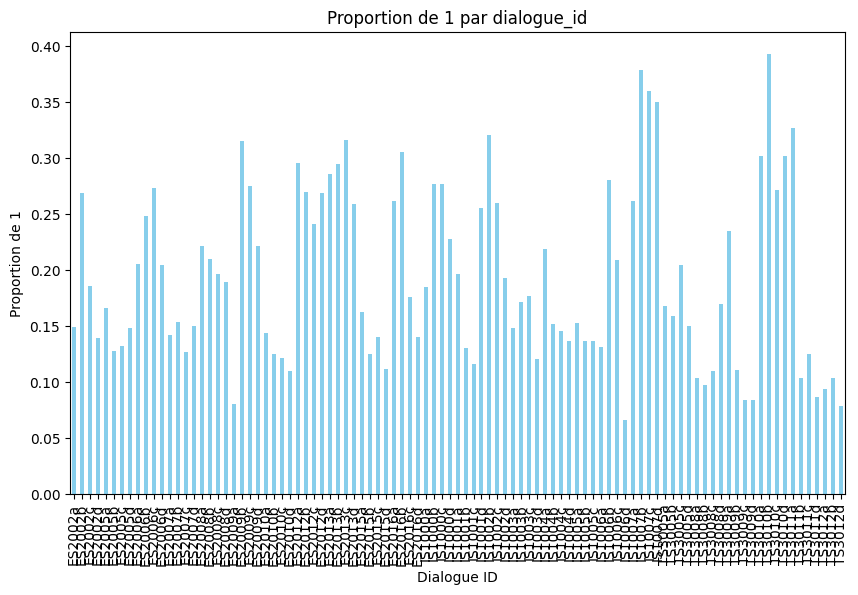

In [55]:
# Groupe par 'dialogue_id' et calcule la somme de la colonne 'label' pour chaque groupe
label_sum_per_dialogue = df.groupby('dialogue_id')['label'].sum()

# Groupe par 'dialogue_id' et calcule le nombre total de lignes pour chaque groupe
total_rows_per_dialogue = df.groupby('dialogue_id').size()

# Calcule la proportion en divisant la somme des labels par le nombre total de lignes pour chaque groupe
proportion_of_1_per_dialogue = label_sum_per_dialogue / total_rows_per_dialogue

proportion_of_1_per_dialogue.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Proportion de 1 par dialogue_id')
plt.xlabel('Dialogue ID')
plt.ylabel('Proportion de 1')
plt.show()


In [5]:
df['bert'] = df['text']
for transcription_id in training_set:
    bert_array = np.load('feature-extraction/bert/training/' + transcription_id + '.npy')
    
    # Obtenez les indices des lignes correspondant à la transcription_id
    indices = df[df['dialogue_id'] == transcription_id].index
    
    # Remplacez les valeurs de la colonne 'text' par les valeurs de bert_array
    for idx, value in enumerate(bert_array):
        df.at[indices[idx-1], 'bert'] = value

df_test['bert'] = df_test['text']
for transcription_id in test_set:
    bert_array_test = np.load('feature-extraction/bert/test/' + transcription_id + '.npy')
    
    # Obtenez les indices des lignes correspondant à la transcription_id
    indices = df_test[df_test['dialogue_id'] == transcription_id].index
    
    # Remplacez les valeurs de la colonne 'text' par les valeurs de bert_array
    for idx, value in enumerate(bert_array_test):
        df_test.at[indices[idx-1], 'bert'] = value


In [6]:
# Nombre d'éléments dans chaque liste
num_elements = len(df['bert'].iloc[0])

# Créez de nouvelles colonnes pour chaque élément dans la liste
new_columns = [f'coord_{i}' for i in range(num_elements)]

# Appliquez une fonction qui divise chaque liste en plusieurs colonnes
new_text_columns = df['bert'].apply(pd.Series)

# Renommez les nouvelles colonnes avec les noms spécifiques
new_text_columns.columns = new_columns

# Concaténez les nouvelles colonnes avec le DataFrame existant
df = pd.concat([df, new_text_columns], axis=1)


# Nombre d'éléments dans chaque liste
num_elements = len(df_test['bert'].iloc[0])

# Appliquez une fonction qui divise chaque liste en plusieurs colonnes
new_text_columns_test = df_test['bert'].apply(pd.Series)

# Renommez les nouvelles colonnes avec les noms spécifiques
new_text_columns_test.columns = new_columns

# Concaténez les nouvelles colonnes avec le DataFrame existant
df_test = pd.concat([df_test, new_text_columns_test], axis=1)


In [55]:
df['nb_words_more_8'] = df['text'].apply(lambda x: sum(len(mot) >= 8 and mot.lower() != '<vocalsound>' for mot in x.split()))

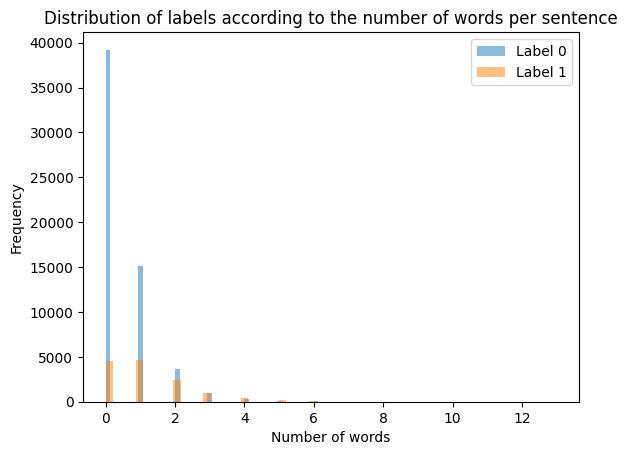

In [56]:
import matplotlib.pyplot as plt

label_0_data = df[df['label'] == 0]['nb_words_more_8']
label_1_data = df[df['label'] == 1]['nb_words_more_8']

plt.hist(label_0_data, bins=60, alpha=0.5, label='Label 0')
plt.hist(label_1_data, bins=60, alpha=0.5, label='Label 1')

plt.xlabel('Number of words')
plt.ylabel('Frequency')

# Ajout d'un titre
plt.title('Distribution of labels according to the number of words per sentence')

# Ajout d'une légende
plt.legend()

# Affichage du graphique
plt.show()

In [9]:
df['word_count'] = df['text'].apply(lambda x: len(x.split(' ')))

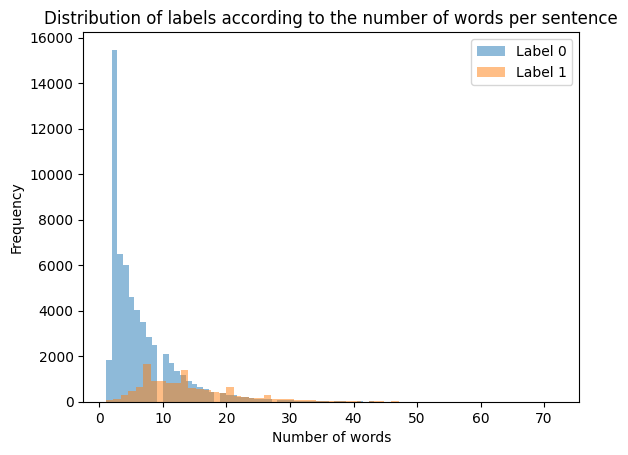

In [41]:
import matplotlib.pyplot as plt

label_0_data = df[df['label'] == 0]['word_count']
label_1_data = df[df['label'] == 1]['word_count']

plt.hist(label_0_data, bins=60, alpha=0.5, label='Label 0')
plt.hist(label_1_data, bins=60, alpha=0.5, label='Label 1')

plt.xlabel('Number of words')
plt.ylabel('Frequency')

# Ajout d'un titre
plt.title('Distribution of labels according to the number of words per sentence')

# Ajout d'une légende
plt.legend()

# Affichage du graphique
plt.show()


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
# TFIDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

# Somme des Scores TF-IDF par phrase
df['tfidf_sum'] = tfidf_matrix.sum(axis=1)

# Score TF-IDF maximum par phrase
df['tfidf_max'] = tfidf_matrix.max(axis=1).toarray().flatten()

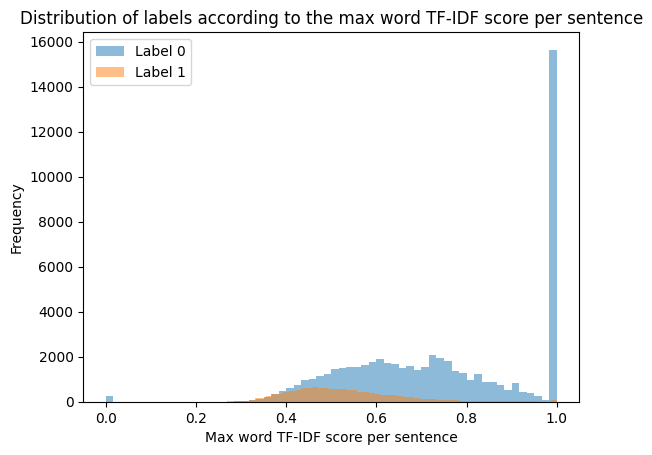

In [48]:
label_0_data = df[df['label'] == 0]['tfidf_max']
label_1_data = df[df['label'] == 1]['tfidf_max']

plt.hist(label_0_data, bins=60, alpha=0.5, label='Label 0')
plt.hist(label_1_data, bins=60, alpha=0.5, label='Label 1')

plt.xlabel('Max word TF-IDF score per sentence')
plt.ylabel('Frequency')

# Ajout d'un titre
plt.title('Distribution of labels according to the max word TF-IDF score per sentence')

# Ajout d'une légende
plt.legend()

# Affichage du graphique
plt.show()


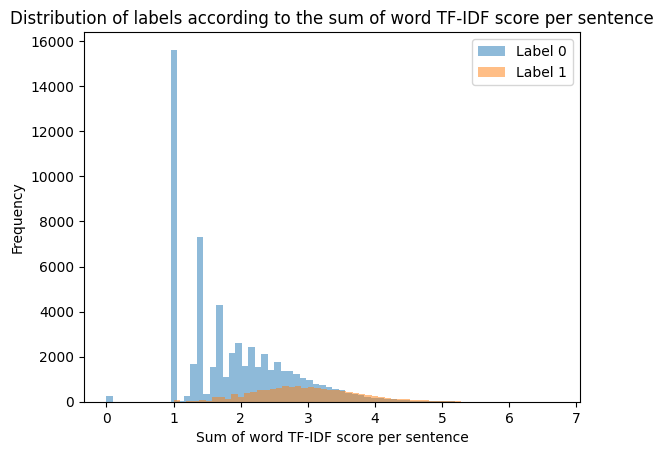

In [50]:
label_0_data = df[df['label'] == 0]['tfidf_sum']
label_1_data = df[df['label'] == 1]['tfidf_sum']

plt.hist(label_0_data, bins=60, alpha=0.5, label='Label 0')
plt.hist(label_1_data, bins=60, alpha=0.5, label='Label 1')

plt.xlabel('Sum of word TF-IDF score per sentence')
plt.ylabel('Frequency')

# Ajout d'un titre
plt.title('Distribution of labels according to the sum of word TF-IDF score per sentence')

# Ajout d'une légende
plt.legend()

# Affichage du graphique
plt.show()


In [51]:
df.head(2)

,dialogue_id,index,text,speaker_text,label,bert,coord_0,coord_1,coord_2,coord_3,...,tfidf_8357,tfidf_8358,tfidf_8359,tfidf_8360,tfidf_8361,tfidf_8362,tfidf_8363,tfidf_8364,tfidf_8365,tfidf_8366
0,ES2002a,0,Okay,PM,0,"[-0.054861926, 0.047606602, -0.032625835, -0.0...",-0.054862,0.047607,-0.032626,-0.010949,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ES2002a,1,Right,PM,0,"[-0.054665036, -0.073837034, -0.017160872, -0....",-0.054665,-0.073837,-0.017161,-0.064276,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
X = df.drop(['dialogue_id','text','speaker_text','bert','label'],axis=1)
y = df[['label']]

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
# Initialiser le modèle
model = KNeighborsClassifier()

#Train the model
model.fit(X_train, y_train)

#Predictions
y_pred = model.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nRésultats du modèle :")
print("Accuracy: ", accuracy)
print("F1-score: ", f1)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

conf_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

print("\nMatrice de confusion :")
print(conf_df)

C:\Users\arnau\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)



Résultats du modèle :
Accuracy:  0.8004819277108434
F1-score:  0.22096774193548388

Matrice de confusion :
          Predicted 0  Predicted 1
Actual 0        11216          671
Actual 1         2227          411
